1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [134]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [177]:
from sklearn.model_selection import GridSearchCV

In [135]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

In [136]:
from sklearn.preprocessing import MinMaxScaler

In [137]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [138]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [139]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [140]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Exited', axis=1), df['Exited'], random_state=42)

In [141]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class NumberScaler(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []
        
    def fit(self, X, y=None):
        self.columns = [col for col in X.columns]
        return self
    
    def transform(self, X):
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
        return X
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [142]:
CreditScore = Pipeline([
                ('selector', NumberSelector(key='CreditScore')),
                ('scaler', NumberScaler(key='CreditScore'))
            ])
CreditScore.fit(X_train)
CreditScore.transform(X_test)

array([[0.492],
       [0.546],
       [0.502],
       ...,
       [0.836],
       [0.68 ],
       [0.508]])

In [143]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [144]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', NumberScaler(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [145]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [146]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

In [147]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

In [148]:
preds_gb = pipeline.predict_proba(X_test)[:, 1]
preds_gb[:10]

array([0.06211875, 0.03753384, 0.09999524, 0.21780201, 0.09036757,
       0.01926406, 0.12068039, 0.24544122, 0.32016528, 0.49675222])

In [149]:
models_results = {
    'Model': [],
    'Best Threshold': [],
    'F-Score': [],
    'Precision': [],
    'Recall': [],
    'roc_auc': [],
}

In [150]:
result_df = pd.DataFrame.from_dict(models_results)

In [151]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test, preds_gb)
fscore = (1 + b ** 2) * (precision * recall) / (b ** 2 * precision + recall)
roc_auc = roc_auc_score(y_test, preds_gb)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]:.3f}, '\
      f'F-Score={fscore[ix]:.3f}, '\
      f'Precision={precision[ix]:.3f}, '\
      f'Recall={recall[ix]:.3f} '\
      f'roc_auc={roc_auc:.3f}')

Best Threshold=0.353, F-Score=0.638, Precision=0.642, Recall=0.634 roc_auc=0.867


In [152]:
result_df = result_df.append({'Model' : 'GradientBoosting',
                          'Best Threshold' : thresholds[ix],
                          'F-Score' : fscore[ix],
                          'Precision' : precision[ix],
                          'Recall' : recall[ix],
                          'roc_auc' : roc_auc}, ignore_index=True)

In [153]:
result_df

,Model,Best Threshold,F-Score,Precision,Recall,roc_auc
0,GradientBoosting,0.352921,0.637652,0.641548,0.633803,0.86707


In [154]:
from sklearn.linear_model import LogisticRegression

In [155]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(class_weight={0: 1, 1: 4}, random_state = 42)),
])

In [156]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

In [157]:
preds_lr = pipeline.predict_proba(X_test)[:, 1]
preds_lr[:10]

array([0.5495709 , 0.26775561, 0.62746106, 0.78239086, 0.23475798,
       0.1652359 , 0.59668987, 0.49903276, 0.64723121, 0.67205422])

In [158]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test, preds_lr)
fscore = (1 + b ** 2) * (precision * recall) / (b ** 2 * precision + recall + 1e-6)
roc_auc = roc_auc_score(y_test, preds_lr)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]:.3f}, '\
      f'F-Score={fscore[ix]:.3f}, '\
      f'Precision={precision[ix]:.3f}, '\
      f'Recall={recall[ix]:.3f} '\
      f'roc_auc={roc_auc:.3f}')

Best Threshold=0.633, F-Score=0.504, Precision=0.472, Recall=0.541 roc_auc=0.775


In [159]:
result_df = result_df.append({'Model' : 'LogReg',
                          'Best Threshold' : thresholds[ix],
                          'F-Score' : fscore[ix],
                          'Precision' : precision[ix],
                          'Recall' : recall[ix],
                          'roc_auc' : roc_auc}, ignore_index=True)

In [160]:
result_df

,Model,Best Threshold,F-Score,Precision,Recall,roc_auc
0,GradientBoosting,0.352921,0.637652,0.641548,0.633803,0.867070
1,LogReg,0.633474,0.504217,0.471930,0.541247,0.775319


Какая метрика тут важнее - со стороны DS интереснее найти всех клиентов "1" класса, значит важнее полнота. Со стороны бизнеса - может быть по-разному, зависит от стоимости удержания и прибыльности клиента. В моем случае градиентный бустинг по всем параметрам лучше справился чем логрег, берем его.

In [161]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1971   32]
 [ 309  188]]


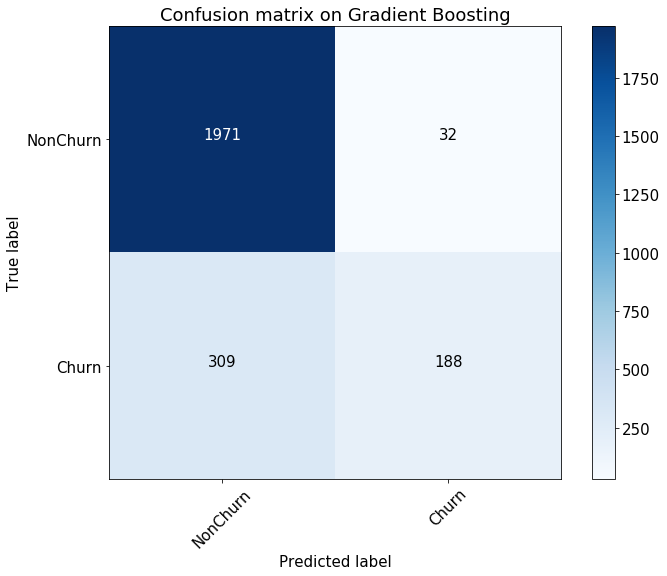

In [164]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_gb>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix on Gradient Boosting')
plt.savefig("conf_matrix.png")
plt.show()

In [181]:
tn = cnf_matrix[0][0]
fp = cnf_matrix[0][1]
fn = cnf_matrix[1][0]
tp = cnf_matrix[1][1]

1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного

In [183]:
add_sum = tp * 2 - (fp + tp) * 1

In [184]:
add_sum

156

Остаемся в плюсе

найдем новый порог для максимальной выгоды

In [189]:
def get_money(y_test, preds):
    add_sum = []
    thresholds = np.linspace(0, 1, 100)
    for i in thresholds:
        cnf_matrix = confusion_matrix(y_test, preds > i)
        add_sum.append(cnf_matrix[1, 1] * 2 - np.sum(cnf_matrix[:, 1]))
    ix = np.argmax(add_sum)
    print(f'Best threshold: {thresholds[ix]:.3f}\n'\
          f'Added sum = {add_sum[ix]}')

In [190]:
get_money(y_test, preds_gb)

Best threshold: 0.596
Added sum = 164


In [176]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

In [191]:
params={'classifier__max_features':['auto', None, 0.3, 0.5, 0.7],
        'classifier__min_samples_leaf':[None, 1, 2, 3],
        'classifier__max_depth':[None, 1, 3, 5]
        }

In [194]:
%%time
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    n_jobs=-1,
                    cv=5,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

Wall time: 2min 36s


{'classifier__max_depth': 1,
 'classifier__max_features': 0.5,
 'classifier__min_samples_leaf': 1}

In [195]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(min_samples_leaf=1, max_depth=1, max_features=0.5, random_state = 42)),
])

In [196]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

In [197]:
preds = pipeline.predict_proba(X_test)[:, 1]

In [198]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (1 + b ** 2) * (precision * recall) / (b ** 2 * precision + recall + 1e-6)
roc_auc = roc_auc_score(y_test, preds)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]:.3f}, '\
      f'F-Score={fscore[ix]:.3f}, '\
      f'Precision={precision[ix]:.3f}, '\
      f'Recall={recall[ix]:.3f} '\
      f'roc_auc={roc_auc:.3f}')

Best Threshold=0.350, F-Score=0.609, Precision=0.664, Recall=0.561 roc_auc=0.850


In [199]:
result_df = result_df.append({'Model' : 'final GradientDoosting',
                          'Best Threshold' : thresholds[ix],
                          'F-Score' : fscore[ix],
                          'Precision' : precision[ix],
                          'Recall' : recall[ix],
                          'roc_auc' : roc_auc}, ignore_index=True)

Confusion matrix, without normalization
[[1862  141]
 [ 220  277]]


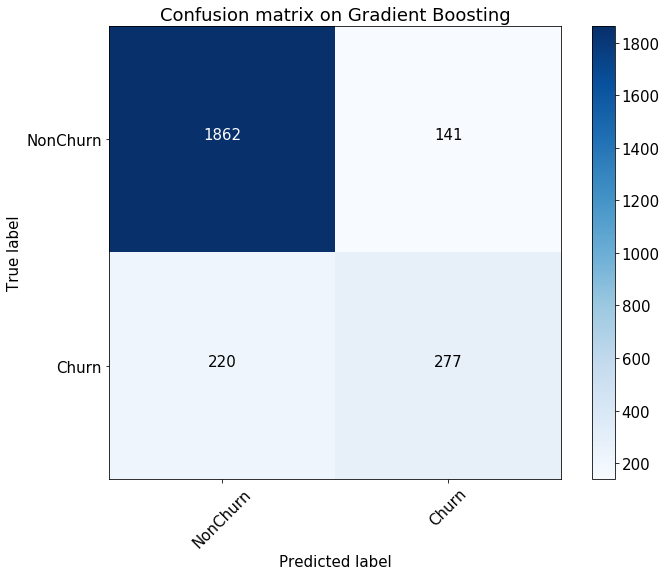

In [204]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix on Gradient Boosting')
plt.savefig("conf_matrix.png")
plt.show()

In [207]:
add_sum = 2 * cnf_matrix[1, 1] - np.sum(cnf_matrix[:, 1])
print(f'Заработанная на удержании сумма при автоматическом пороге {add_sum}')

Заработанная на удержании сумма при автоматическом пороге 136


In [208]:
get_money(y_test, preds)

Best threshold: 0.424
Added sum = 160


Так себе Grid Search вышел, до него было лучше